# fusion_analysis_d23a
BSG, 2023-2024

In [1]:
import d23a
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Get start datetime
start_dt = datetime.datetime.now()

## Figures for manuscript

Written o01.pdf (0.01 MB)
Written o01.png (0.03 MB)
Written o02.pdf (0.01 MB)
Written o02.png (0.02 MB)
Written o03.pdf (0.01 MB)
Written o03.png (0.02 MB)


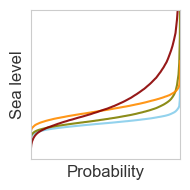

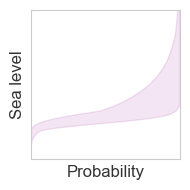

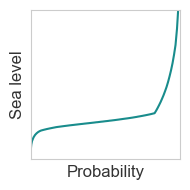

In [3]:
# Panels for schematic figure
for workflows, pbox in ([('wf_1e', 'wf_2e', 'wf_3e', 'wf_4'), False],
                        [(list()), True],
                        [('fusion_1e+2e',), False]):
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    # Plot data
    ax = d23a.plot_sl_qfs(workflows=workflows, bg_workflows=list(), pbox=pbox,
                          rate=False, scenario='ssp585', year=2100, gauge=None, ax=ax)
    # Simplify plot by removing legend etc
    ax.set_ylim((0., 3.))
    ax.get_legend().remove()
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.grid(False)
    ax.set_ylabel('Sea level', fontweight='regular', color='0.2')
    ax.set_xlabel('Probability', fontweight='regular', color='0.2')
    for pos in ax.spines:
        ax.spines[pos].set_color('0.8')
    plt.tight_layout()
    # Save as other figure
    d23a.name_save_fig(fig, fso='o')
# Increase main figure counter
_ = next(d23a.F_NUM)

Written fig02.pdf (0.04 MB)
Written fig02.png (0.27 MB)


'fig02'

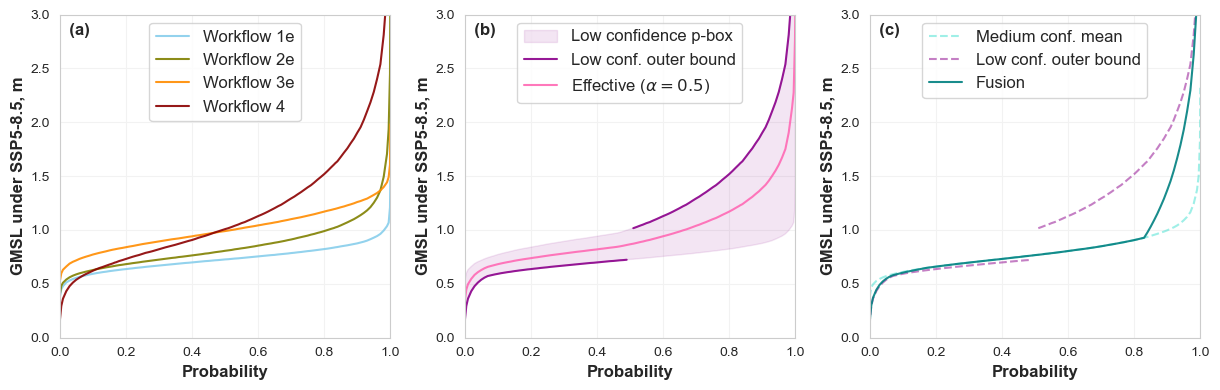

In [4]:
# SSP5 year-2100 AR6 projections, p-box, and fusion
fig, axs = d23a.fig_qfs_marginals(workflows_c=(('wf_1e', 'wf_2e', 'wf_3e', 'wf_4'), ('outer', 'effective_0.5'), ('fusion_1e+2e',)),
                                  bg_workflows_c=(list(), list(), ('mean_1e+2e', 'outer')),
                                  pbox_c=(False, True, False),
                                  rate=False, scenario='ssp585', year=2100, gauge=None, lim=(0., 3.))
d23a.name_save_fig(fig)

Written fig03.pdf (0.02 MB)
Written fig03.png (0.10 MB)


'fig03'

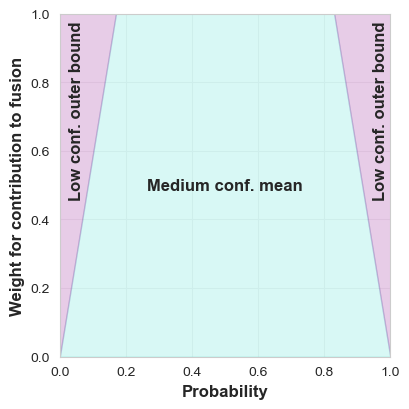

In [5]:
# Weighting function
fig, ax = plt.subplots(1, 1, figsize=(4.2, 4.2), tight_layout=True)
ax = d23a.plot_fusion_weights(ax=ax)
d23a.name_save_fig(fig)

Written fig04.pdf (0.03 MB)
Written fig04.png (0.16 MB)


'fig04'

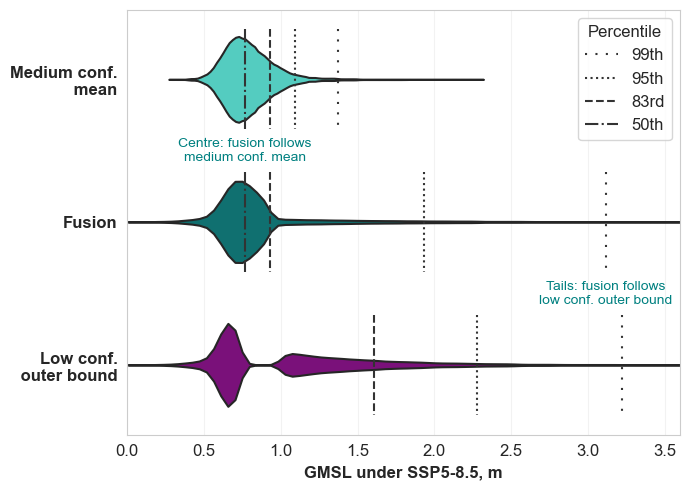

In [6]:
# SSP5 year-2100 violinplot
fig, ax = plt.subplots(1, 1, figsize=(7, 5), tight_layout=True)
ax = d23a.plot_sl_violinplot(workflows=('mean_1e+2e', 'fusion_1e+2e', 'outer'),
                             rate=False, scenario='ssp585', year=2100, gauge=None, annotations=True, ax=ax)
ax.set_xlim([0, 3.6])
d23a.name_save_fig(fig)

Written fig05.pdf (0.02 MB)
Written fig05.png (0.07 MB)


'fig05'

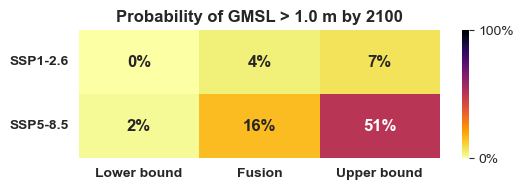

In [7]:
# Heatmap table for probability of exceeding 1m
fig, ax = plt.subplots(1, 1, figsize=(5.5, 2), tight_layout=True)
threshold = 1.0
_ = d23a.plot_exceedance_heatmap(threshold=threshold, workflows=('lower', 'fusion_1e+2e', 'upper'), rate=False,
                                 scenarios=('ssp126', 'ssp585'), year=2100, gauge=None, ax=ax)
ax.set_title(f'Probability of GMSL > {threshold:.1f} m by 2100')
d23a.name_save_fig(fig)

Written fig06.pdf (0.02 MB)
Written fig06.png (0.16 MB)


'fig06'

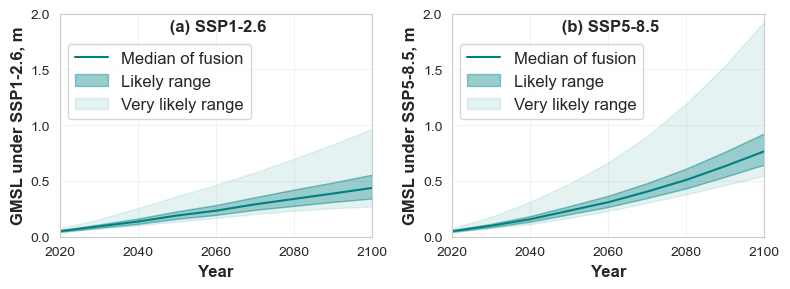

In [8]:
# Time series of median, likely range, and very likely range for different scenarios
fig, axs = d23a.fig_timeseries(scenario_c=('ssp126', 'ssp585'),
                               workflow='fusion_1e+2e', rate=False, gauge=None, ylim=(0., 2.))
for ax in axs:
    ax.set_yticks(np.linspace(0, 2, 5))
d23a.name_save_fig(fig)

## Supplementary figures

Written s01.pdf (0.03 MB)
Written s01.png (0.09 MB)


's01'

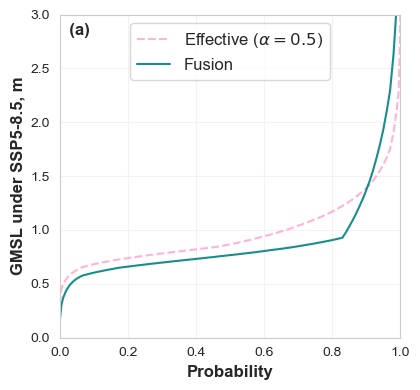

In [9]:
# SSP5 year-2100 effective_0.5 and fusion_1e+2e
fig, axs = d23a.fig_qfs_marginals(workflows_c=(('fusion_1e+2e',),),
                                  bg_workflows_c=(('effective_0.5',),),
                                  pbox_c=(False,),
                                  rate=False, scenario='ssp585', year=2100, gauge=None, lim=(0, 3.))
d23a.name_save_fig(fig, fso='s')

Written s02.pdf (0.02 MB)
Written s02.png (0.29 MB)


's02'

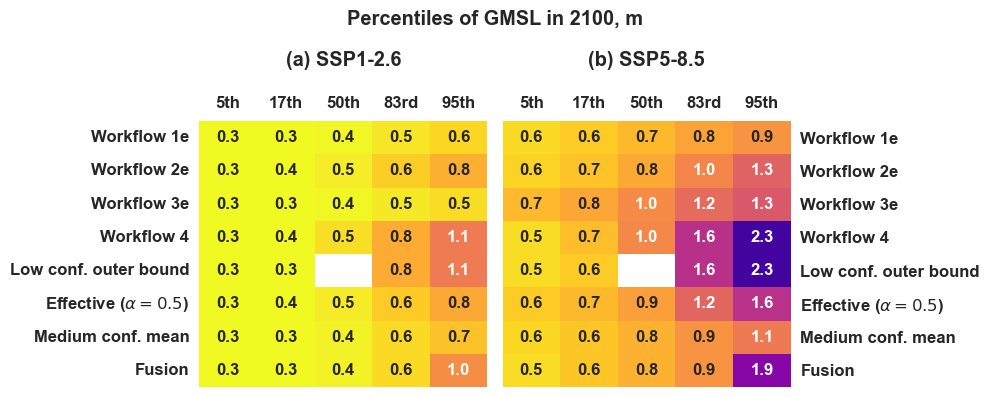

In [10]:
# Heatmap table of SSP5 year-2100 sea level percentiles
fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
for scenario, ab, ax in zip(['ssp126', 'ssp585'], ['a', 'b'], axs):
    d23a.plot_percentiles_heatmap(percentiles=('5th', '17th', '50th', '83rd', '95th'),
                                  workflows=('wf_1e', 'wf_2e', 'wf_3e', 'wf_4', 'outer', 'effective_0.5', 'mean_1e+2e',
                                             'fusion_1e+2e'),
                                  rate=False, scenario=scenario, year=2100, gauge=None, fmt='.1f', ax=ax)
    ax.set_title(f'({ab}) {d23a.SSP_LABEL_DICT[scenario]}\n', fontsize='x-large')
axs[1].tick_params(labelleft=False, labelright=True)  # shift y-axis labels in (b) to the right
for label in axs[0].get_yticklabels() + axs[1].get_yticklabels():  # ensure consistent formatting of y-axis labels
    label.set_fontweight('bold')
    label.set_fontsize('large')
fig.suptitle('Percentiles of GMSL in 2100, m')
d23a.name_save_fig(fig, fso='s')

## Other figures

plot_sl_marginals() has been called.
plot_sl_marginals() has been called.
Written o04.pdf (0.03 MB)
Written o04.png (0.34 MB)


'o04'

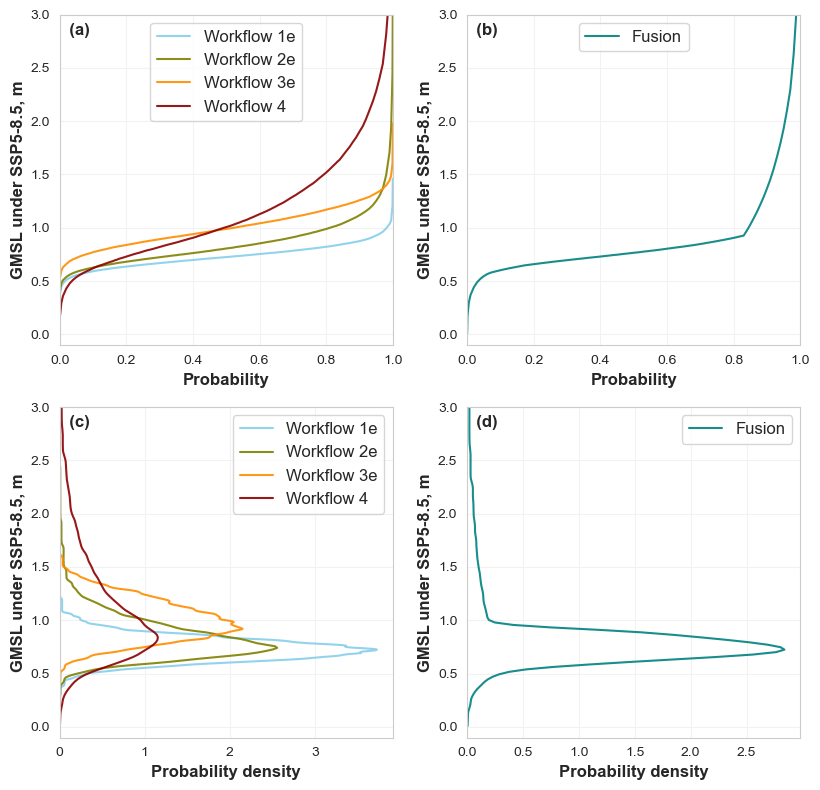

In [11]:
# SSP5 year-2100 AR6 projections and fusion
fig, axs = d23a.fig_qfs_marginals(workflows_c=(('wf_1e', 'wf_2e', 'wf_3e', 'wf_4'), ('fusion_1e+2e',)),
                                  bg_workflows_c=(list(), list()),
                                  pbox_c=(False, False),
                                  rate=False, scenario='ssp585', year=2100, gauge=None, lim=(-0.1, 3.), show_densities=True)
d23a.name_save_fig(fig, fso='o')

## Watermark and timing info

In [12]:
print(d23a.get_watermark())

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.13.2

matplotlib: 3.7.1
numpy     : 1.24.3
pandas    : 2.0.2
seaborn   : 0.12.2
xarray    : 2023.5.0

conda environment: d23a-fusion

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit


In [13]:
# Get end datetime
end_dt = datetime.datetime.now()
# Calculate run timedelta
run_td = end_dt - start_dt
# Print timing information
print(f"Start:     {start_dt.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"End:       {end_dt.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Wall time: {run_td.seconds} s")

Start:     2024-08-29 14:57:18
End:       2024-08-29 14:57:36
Wall time: 18 s
